# Литература
[Practitioner’s Guide to Statistical Tests](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3)

[А/Б тесты с метрикой отношения. Дельта-метод](https://habr.com/ru/companies/X5Tech/articles/740476/)

[A/B-тесты с метриками-отношениями и при чём здесь внутрипользовательские корреляции](https://www.youtube.com/watch?v=ObzlKVCiBqI&list=PLAynZk3jFRd_81lZ1W0E9XEyXtAljkBlh&index=7&t=5201s)

In [90]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy import stats
from scipy.stats import norm, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

# Генерация данных

In [92]:
def get_session_duration(size, effect=0, seed=None):

    def _user_sessions(mean):
        size = np.random.randint(3, 10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    
    return [_user_sessions(mean) for mean in mean_durations]

# Направленность метрик

In [93]:
list_session_mean = []
list_user_avg_mean = []

def get_naive_mean_delta(a, b):
    return np.concatenate(b).mean() - np.concatenate(a).mean()

def get_user_avg_mean_delta(a, b):
    return np.mean([t.mean() for t in b]) - np.mean([t.mean() for t in a])

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    list_session_mean.append(get_naive_mean_delta(a, b))
    list_user_avg_mean.append(get_user_avg_mean_delta(a, b))
    
df = pd.DataFrame({'list_session_mean': list_session_mean,
                   'list_user_avg_mean': list_user_avg_mean
                  })
df['sign'] = (df['list_session_mean'] * df['list_user_avg_mean']) >= 0

  0%|          | 0/1000 [00:00<?, ?it/s]

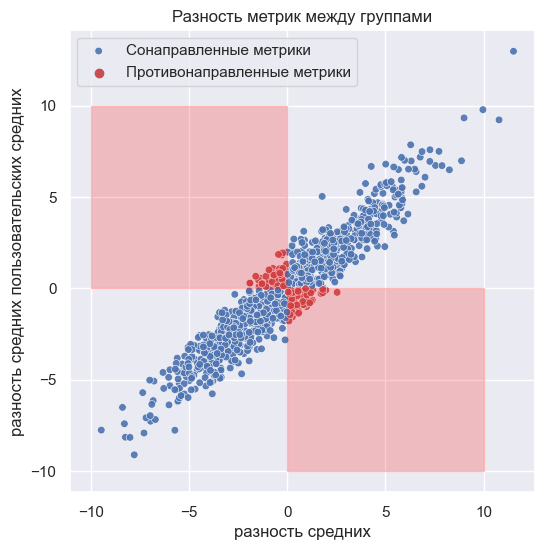

In [120]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df,
                x=df.list_session_mean, 
                y=df.list_user_avg_mean, 
                hue = 'sign', 
                s=30, 
                alpha=0.9, 
                palette=['r', 'b'])

plt.fill_between([-10, -10, 0, 0, 0, 0, 10, 10], [0, 10, 10, 0, 0, -10, -10, 0], color='red', alpha=0.2)
plt.legend(['Сонаправленные метрики', 'Противонаправленные метрики'])

plt.ylabel('разность средних пользовательских средних')
plt.xlabel('разность средних')
plt.title('Разность метрик между группами')
plt.show()

# Бутстреп

In [59]:
def check_bootstrap(a, b, n=1000):
    """Проверка гипотезы с помощью бутстрепа по пользователям.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    n: int, кол-во итераций бутстрепа
    
    return: pvalue и точечную оценку.
    """
    len_a = len(a)
    len_b = len(b)
    # предобработаем данные
    # посчитаем заранее сумму длин сессий и их кол-во для каждого пользователя
    a_sum_count = np.zeros((len_a, 2))
    a_sum_count[:, 0] = np.array([np.sum(row) for row in a])
    a_sum_count[:, 1] = np.array([len(row) for row in a])
    b_sum_count = np.zeros((len_b, 2))
    b_sum_count[:, 0] = np.array([np.sum(row) for row in b])
    b_sum_count[:, 1] = np.array([len(row) for row in b])
    
    list_diff = []
    for _ in range(n):
        a_bootstrap_index = np.random.choice(np.arange(len_a), len_a)
        b_bootstrap_index = np.random.choice(np.arange(len_b), len_b)
        a_bootstrap = a_sum_count[a_bootstrap_index]
        b_bootstrap = b_sum_count[b_bootstrap_index]
        a_metric = a_bootstrap[:, 0].sum() / a_bootstrap[:, 1].sum()
        b_metric = b_bootstrap[:, 0].sum() / b_bootstrap[:, 1].sum()
        list_diff.append(b_metric - a_metric)
    delta = (
        b_sum_count[:, 0].sum() / b_sum_count[:, 1].sum()
        - a_sum_count[:, 0].sum() / a_sum_count[:, 1].sum()
    )
    std = np.std(list_diff)
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(delta / std)))
    return pvalue, delta

In [60]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    pvalue, delta = check_bootstrap(a, b)
    list_real_delta.append(get_naive_mean_delta(a, b))
    list_delta.append(delta)
    list_pvalue.append(pvalue)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [88]:
def plot_scattert_and_ecdf(list_pvalue, list_delta, list_real_delta):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.scatterplot(x=list_real_delta, y=list_delta, ax=ax1, s=10, alpha=0.9)
    ax1.set(xlabel='real delta', ylabel='bootstrap delta')
    ax1.set_title('Разность метрик между группами')    

    # empirical cumulative distribution functions
    sns.ecdfplot(list_pvalue, ax=ax2, stat='proportion')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.set_title('Функция распределения pvalue')

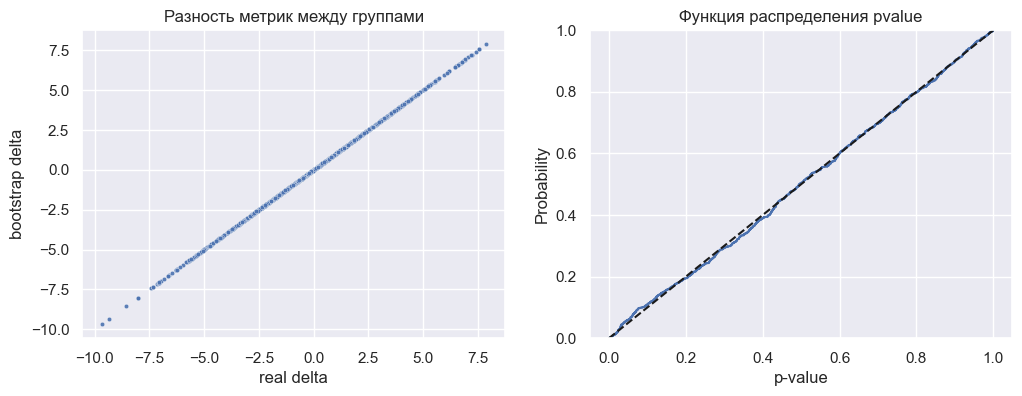

In [89]:
plot_scattert_and_ecdf(list_pvalue, list_delta, list_real_delta)

# Линеаризация

In [122]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффекта нет


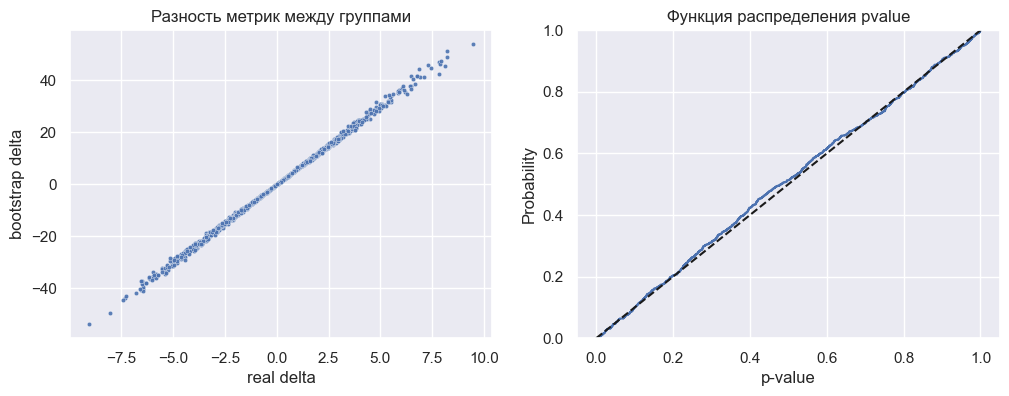

In [123]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_linearization(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффекта нет')
plot_scattert_and_ecdf(list_pvalue, list_delta, list_real_delta)